In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet34


In [2]:
# 1. 数据预处理部分
# 定义数据预处理操作，将图像转换为 Tensor 并进行归一化
# 这里增加了数据增强操作，如随机裁剪和随机水平翻转，有助于提高模型的泛化能力
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪图像，大小为 32x32，四周填充 4 个像素
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.ToTensor(),  # 将图像转换为 Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化处理，均值和标准差都为 0.5
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # 测试集只需要转换为 Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化处理
])

In [6]:
# 2. 数据集加载部分
# 下载并加载 CIFAR-10 训练数据集
train_data = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)  # num_workers 用于多线程数据加载

# 下载并加载 CIFAR-10 测试数据集
test_data = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

# 查看数据集大小
print(f"训练集样本数: {len(train_data)}, 测试集样本数: {len(test_data)}")

Files already downloaded and verified
Files already downloaded and verified
训练集样本数: 50000, 测试集样本数: 10000


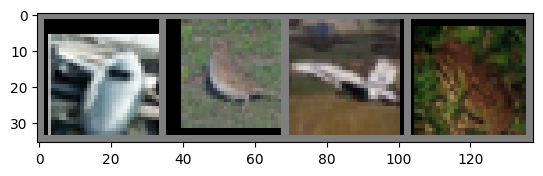

Labels: tensor([0, 2, 0, 6])


In [7]:
# 3. 可视化部分
# 定义函数：将 Tensor 格式的图片转换为可视化的 numpy 格式
def imshow(img):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 调整维度顺序以适应 matplotlib
    plt.show()

# 获取一批训练数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 显示前 4 张图片
imshow(torchvision.utils.make_grid(images[:4]))
print(f"Labels: {labels[:4]}")

In [9]:
# 4. 模型定义部分
# 定义 LeNet 网络结构
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 输入通道数 3，输出通道数 6，卷积核大小 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)  # 输入通道数 6，输出通道数 16，卷积核大小 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 全连接层，输入维度 16 * 5 * 5，输出维度 120
        self.fc2 = nn.Linear(120, 84)  # 全连接层，输入维度 120，输出维度 84
        self.fc3 = nn.Linear(84, 10)  # 全连接层，输入维度 84，输出维度 10（对应 10 个类别）

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 卷积层 1 后接 ReLU 激活函数
        x = F.max_pool2d(x, 2)  # 最大池化层，池化核大小 2x2
        x = F.relu(self.conv2(x))  # 卷积层 2 后接 ReLU 激活函数
        x = F.max_pool2d(x, 2)  # 最大池化层，池化核大小 2x2
        x = torch.flatten(x, 1)  # 将多维张量展平为一维
        x = F.relu(self.fc1(x))  # 全连接层 1 后接 ReLU 激活函数
        x = F.relu(self.fc2(x))  # 全连接层 2 后接 ReLU 激活函数
        x = self.fc3(x)  # 全连接层 3，输出最终结果
        return x

# 创建 LeNet 模型实例
lenet = LeNet()
print(lenet)

# 创建 ResNet34 模型实例，并调整最后一层全连接层的输出维度为 10
resnet = resnet34(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)
print(resnet)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, e

In [10]:
# 5. 训练和评估部分
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

# 定义训练和评估函数
def train_and_evaluate(model, model_name):
    model.to(device)  # 将模型移动到指定设备

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 优化器，学习率为 0.001
    # 学习率调度器，每 3 个 epoch 将学习率降低为原来的 0.1 倍，有助于模型在训练后期收敛
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    epochs = 10  # 训练 10 轮
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # 将模型设置为训练模式
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)  # 将数据移动到指定设备

            optimizer.zero_grad()  # 梯度清零
            outputs = model(images)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

            running_loss += loss.item()

        scheduler.step()  # 更新学习率
        print(f"{model_name} Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    print(f"{model_name} 训练完成！")

    correct = 0
    total = 0
    model.eval()  # 将模型设置为评估模式
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # 将数据移动到指定设备
            outputs = model(images)  # 前向传播
            _, predicted = torch.max(outputs, 1)  # 获取预测结果
            total += labels.size(0)  # 累计样本总数
            correct += (predicted == labels).sum().item()  # 累计正确预测的样本数

    print(f"{model_name} 测试集准确率: {100 * correct / total:.2f}%")

# 训练和评估 LeNet 模型
train_and_evaluate(lenet, "LeNet")

# 训练和评估 ResNet34 模型
train_and_evaluate(resnet, "ResNet34")

LeNet Epoch 1, Loss: 1.765462007668927
LeNet Epoch 2, Loss: 1.5001940292775477
LeNet Epoch 3, Loss: 1.3837897289744423
LeNet Epoch 4, Loss: 1.2910250384179527
LeNet Epoch 5, Loss: 1.2756004811400343
LeNet Epoch 6, Loss: 1.2635874004315233
LeNet Epoch 7, Loss: 1.2509949967227019
LeNet Epoch 8, Loss: 1.2520614911223311
LeNet Epoch 9, Loss: 1.249023288183505
LeNet Epoch 10, Loss: 1.2470059473343822
LeNet 训练完成！
LeNet 测试集准确率: 57.77%
ResNet34 Epoch 1, Loss: 1.6314963866072847
ResNet34 Epoch 2, Loss: 1.2517853093421674
ResNet34 Epoch 3, Loss: 1.0853261145027093
ResNet34 Epoch 4, Loss: 0.8359372183642424
ResNet34 Epoch 5, Loss: 0.7790930528393791
ResNet34 Epoch 6, Loss: 0.7474828716129294
ResNet34 Epoch 7, Loss: 0.7030686787555894
ResNet34 Epoch 8, Loss: 0.6945462473822982
ResNet34 Epoch 9, Loss: 0.6915861939454018
ResNet34 Epoch 10, Loss: 0.6838507755942966
ResNet34 训练完成！
ResNet34 测试集准确率: 76.74%


In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"numpy version: {np.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121
matplotlib version: 3.10.1
numpy version: 2.1.2
